{'loss': [0.911404550075531, 0.9091618657112122, 0.9068905711174011, 0.9046575427055359, 0.9024195671081543, 0.90020352602005, 0.8979323506355286, 0.895780086517334, 0.8935832977294922, 0.8913116455078125, 0.8891559839248657, 0.8869205117225647, 0.8847339749336243, 0.8825318813323975, 0.88038569688797, 0.8781178593635559, 0.8760401606559753, 0.8738335967063904, 0.8717230558395386, 0.8695557713508606, 0.8674758672714233, 0.8651037812232971, 0.8632148504257202, 0.861083984375, 0.8588742017745972, 0.8568472862243652, 0.8546265363693237, 0.852632999420166, 0.8505159616470337, 0.8484529256820679, 0.8461733460426331, 0.8443669080734253, 0.8421002626419067, 0.8399374485015869, 0.8379892706871033, 0.8358674645423889, 0.8339107036590576, 0.8317027688026428, 0.8297830820083618, 0.8276112079620361, 0.8255318999290466, 0.8237360715866089, 0.8212562799453735, 0.8195271492004395, 0.8174788355827332, 0.8155625462532043, 0.8138152956962585, 0.8112409710884094, 0.8094160556793213, 0.8074862957000732, 0

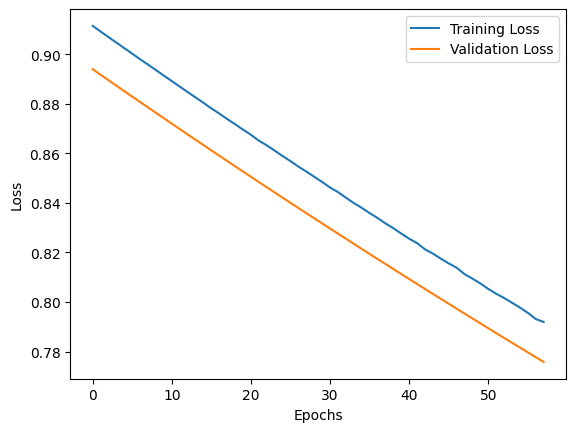

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7876 
==================================== MSE: 0.7872827649116516
Epoch 1/63
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.9120

KeyboardInterrupt: 

In [5]:

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

import matplotlib.pyplot as plt


class LSTMModel:
    def __init__(self, input_shape, units=50, dropout_rate=0.2, 
                 num_layers=1, activation='tanh'):
        self.model = Sequential()
        
        for i in range(num_layers):
            return_sequences = i < num_layers - 1  # Only the last layer should not return sequences
            if i == 0:
                self.model.add(LSTM(units, return_sequences=return_sequences, 
                                    activation=activation, input_shape=input_shape))
            else:
                self.model.add(LSTM(units, return_sequences=return_sequences, 
                                    activation=activation))
            self.model.add(Dropout(dropout_rate))

        self.model.add(Dense(output_steps))  # Final dense layer for output

    def compile(self, optimizer='adam', learning_rate=0.0005):
        """
        Compiles the model with the specified optimizer and learning rate.
        
        Parameters:
        - optimizer: Type of optimizer to use ('adam', 'rmsprop', 'sgd').
        - learning_rate: Learning rate for the optimizer.
        """
        if optimizer == 'adam':
            optimizer_instance = Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            optimizer_instance = RMSprop(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            optimizer_instance = SGD(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported optimizer")

        self.model.compile(optimizer=optimizer_instance, loss='mean_squared_error')

    def fit(self, X_train, y_train, epochs=100, batch_size=32, patience=5, is_validation=False):
        early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)
        trained_model = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                       validation_split=.2, callbacks=[early_stopping])

        from IPython.display import clear_output
        clear_output(wait=True)  # Update output without scrolling down
        print(trained_model.history)
        if (trained_model.history and not is_validation):
            plt.plot(trained_model.history['loss'], label='Training Loss')
            plt.plot(trained_model.history['val_loss'], label='Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
        
        return trained_model.history['loss'], trained_model.history['val_loss']

    def predict(self, X_test):
        return self.model.predict(X_test)

    def evaluate(self, X_test, y_test):
        mse = self.model.evaluate(X_test, y_test)
        return mse 
        

class PSOHyperparameterOptimization:
    def __init__(self, model_class, param_bounds, n_particles=30, n_iterations=50):
        self.model_class = model_class
        self.param_bounds = param_bounds
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.best_scores = []

    def optimize(self, X_train, y_train, input_shape):
        for i in range(self.n_iterations):
            # Sample parameters for each particle
            params = {
                'input_shape': input_shape,  # Include the input shape for the model
                'units': int(np.random.uniform(*self.param_bounds['units'])),  # Number of LSTM units
                'dropout_rate': np.random.uniform(*self.param_bounds['dropout_rate']),  # Dropout rate
                'num_layers': int(np.random.uniform(*self.param_bounds['num_layers'])),  # Number of LSTM layers
                'activation': np.random.choice(self.param_bounds['activation']),  # Activation function
                'epochs': np.random.choice(self.param_bounds['epochs']),
                'optimizer': np.random.choice(self.param_bounds['optimizer']),
                'learning_rate': np.random.uniform(*self.param_bounds['learning_rate']),

            }

            # Create and compile the model
            model = self.model_class(input_shape, units=params['units'], dropout_rate=params['dropout_rate'], 
                 num_layers=params['num_layers'], activation=params['activation'])
            # Compile the model with the specific optimizer and learning rate
            model.compile(optimizer=params['optimizer'], learning_rate=params['learning_rate'])
            # Fit the model with the specific parameters
            model.fit(X_train, y_train, epochs=int(np.random.uniform(*self.param_bounds['epochs'])), batch_size=int(np.random.uniform(*self.param_bounds['batch_size'])), 
                      patience=int(np.random.uniform(*self.param_bounds['patience'])))

            # Evaluate the model
            score = model.evaluate(X_train, y_train)
            params['score'] = score

            self.best_scores.append(params)
        
            self.best_scores = sorted(self.best_scores, key=lambda x: x['score'])            

            if len(self.best_scores) > 5:
                self.best_scores.pop()

        return self.best_scores


base_path = './dataset/'

# carregando arquivo CSV
time_base = 'days'  # Escolha do tipo de agrupamento
duas_unas_dataset = f'{base_path}duas_unas/{time_base}/grouped_1_{time_base}.csv'  # Definição do caminho do diretório do dataset
print(len(duas_unas_dataset))
validation_interval = 97  # Definição da parcela dos dados que serão retiradas do treinamento/teste para validação
time_step = 1  # Number of previous time steps to consider
output_steps = 15  # Number of future steps to predict

# transformando CSV em DataFrame
duas_unas_df = pd.read_csv(duas_unas_dataset)  # Transformação em dataset

duas_unas_validation = duas_unas_df.tail(validation_interval)  # Criação do dataset de validação

indices_to_validate = duas_unas_df.index[-validation_interval:].tolist()  # Obtenção dos índices dos dadoss de validação
duas_unas_df = duas_unas_df.drop(indices_to_validate).reset_index(drop=True)  # Retirada dos dados de validação do dataset original de treino/teste

duas_unas_df['timestamp'] = pd.to_datetime(duas_unas_df['timestamp'])  # Transformação dos dados da coluna 'timestamp' no formato datetime. Ela lida com vários formatos de data/hora e tenta interpretá-los de forma inteligente.
duas_unas_validation['timestamp'] = pd.to_datetime(duas_unas_validation['timestamp'])  # Idem da ação da linha de cima.

duas_unas_df['index'] = range(len(duas_unas_df))  # Criação da coluna 'index' em que os valores vão de zero ao tamanho total do daframe
duas_unas_validation['index'] = indices_to_validate  # Idem da acima da linha acima
print(indices_to_validate)
duas_unas_df['kwh'] = duas_unas_df['kWh fornecido']  # Criação da coluna 'kwh' que copia os dados da coluna 'kWh fornecido'
duas_unas_validation['kwh'] = duas_unas_validation['kWh fornecido']  # Idem da acima da linha acima

duas_unas_df.drop(columns=['timestamp'], inplace=True)  # Remoção da coluna 'timestamp', inclusive no dataframe original
duas_unas_validation.drop(columns=['timestamp'], inplace=True)  # Idem da acima da linha acima

duas_unas_df.drop(columns=['kWh fornecido'], inplace=True)  # Remoção da coluna 'kWh fornecido', inclusive no dataframe original
duas_unas_validation.drop(columns=['kWh fornecido'], inplace=True)  # Idem da acima da linha acima

X = duas_unas_df['index'].values.reshape(-1,1)  # Cria o array X com os índices do dataframe duas_unas_df
y = duas_unas_df['kwh'].values  # Cria o array y com os dados de energia de duas_unas_df
#print(y)
X_validation = duas_unas_validation['index'].values.reshape(-1,1)  # Cria o array X_validation com os índices do dataframe duas_unas_validation
y_validation = duas_unas_validation['kwh'].values  # Cria o array y com os dados de energia de duas_unas_validation
y_validation_plot = duas_unas_validation['kwh'].values
#print(X_validation)

scaler = MinMaxScaler(feature_range=(0, 1))  # Padronização dos dados
scaled_kwh = scaler.fit_transform(duas_unas_df['kwh'].values.reshape(-1, 1))  # padronização de duas_unas_df

scaled_kwh_validation = scaler.fit_transform(duas_unas_validation['kwh'].values.reshape(-1,1))  # padronização de duas_unas_validacao

def create_dataset(data, time_step, output_steps):  # Função para construção do dataset
    X, y = [], []  # Criação das listas
    for i in range(len(data) - time_step - output_steps + 1):  # Loop
        X.append(data[i:(i + time_step), 0])  # Construção do dataset 
        y.append(data[(i + time_step):(i + time_step + output_steps), 0])
    return np.array(X), np.array(y)

# Create the dataset
X, y = create_dataset(scaled_kwh, time_step, output_steps)

X_validation, y_validation = create_dataset(scaled_kwh_validation, time_step, output_steps)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


for i in range(0,100,10):
    # Define the parameter bounds
    pso_lst_params = {
        'units': (10, 200),                   # Number of units in LSTM layers
        'dropout_rate': (0.1, 0.5),           # Dropout rate for regularization
        'learning_rate': (1e-5, 1e-2),        # Learning rate for the optimizer
        'optimizer': ["adam", "rmsprop", "sgd"],  # Optimizers
        'activation': ["tanh", "relu", "sigmoid"],  # Activation functions
        'num_layers': (1, 10),                  # Number of LSTM layers
        'epochs': (30, 100),
        'batch_size': (8, 64), 
        'patience': (2, 10),
        'n_iterations': i,
        'n_particles': 30
    }

    output_dir = f'outputs/pso-iterations/#{pso_lst_params["n_iterations"]}_iteration/'
    os.makedirs(output_dir, exist_ok=True)

    # Instantiate PSO for hyperparameter optimization
    pso_optimizer = PSOHyperparameterOptimization(LSTMModel, n_iterations=pso_lst_params['n_iterations']+1, n_particles=pso_lst_params['n_particles'], param_bounds=pso_lst_params)

    # Perform optimization (input_shape should match your data's input dimensions)
    best_scores_ranking = pso_optimizer.optimize(X_train, y_train, input_shape=(X_train.shape[1], 1))

    for (i, best_params) in enumerate(best_scores_ranking):
        # Use the best_params to create and train your final model
        final_model = LSTMModel(input_shape=best_params['input_shape'], units=best_params['units'], dropout_rate=best_params['dropout_rate'], 
                        num_layers=best_params['num_layers'], activation=best_params['activation'])
        final_model.compile()
        final_model.fit(X_train, y_train, epochs=best_params['epochs'], is_validation=True)

        # Step 1: Make predictions on the validation set
        predictions = final_model.predict(X_validation)

        # Step 2: Rescale the predictions back to the original scale
        predictions_rescaled = scaler.inverse_transform(predictions)

        y_validation_plot = duas_unas_validation['kwh'].values

        y_validation_plot = y_validation_plot[:len(predictions_rescaled)]

        plt.figure(i,figsize=(14, 10))
        plt.plot(y_validation_plot, label='Actual kWh', color='blue', linestyle='-', alpha=0.7)
        plt.plot(predictions_rescaled[:,0], label='Predicted kWh', color='red', linestyle='--', alpha=0.7)
        plt.xticks(np.arange(0,len(y_validation_plot), 2))
        plt.title(f'Prediction vs Actual kWh - score {best_params['score']}')
        plt.xlabel('Index')
        plt.ylabel('kWh')
        plt.legend()
        plt.grid() 
        plt.savefig(f'{output_dir}{round(best_params['score'],4)*100}.png')
        pd.DataFrame(best_params).to_json(f'{output_dir}{round(best_params['score'],4)*100}.json')
